In [11]:
import OCC
from OCC.Core.Quantity import Quantity_Color, Quantity_TOC_RGB
import ifcopenshell, ifcopenshell.geom

import sys
import os
sys.path.append(os.path.abspath('..'))
from src import ifcControl

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d

# Open the IFC file using IfcOpenShell
ifc = ifcopenshell.open("../data/IfcOpenHouse_IFC4.ifc")
ifcControl.ifcshow(ifc)

INFO:OCC.Display.backend:The qt-pyqt5 backend is already loaded...``load_backend`` can only be called once per session
INFO:OCC.Display.SimpleGui:GUI backend set to: qt-pyqt5
 ###### 3D rendering pipe initialisation #####
Display3d class initialization starting ...
Aspect_DisplayConnection created.
Graphic_Driver created.
V3d_Viewer created.
AIS_InteractiveContext created.
V3d_View created
Xw_Window created.
Display3d class successfully initialized.
 ########################################


In [52]:
#https://sourceforge.net/p/ifcopenshell/discussion/1782716/thread/6e9f0aee79/
# https://framagit.org/pythonhvac/pythoncvc-net/blob/master/IfcOpenShellSamples/ifc_placement.py
# https://pythoncvc.net/?cat=183
# https://sourceforge.net/p/ifcopenshell/discussion/1782717/thread/409ef11620/

# Get a list of all walls in the file
products = ifc.by_type("IfcProduct")
settingsGeom = ifcopenshell.geom.settings()
settingsGeom.set(settingsGeom.USE_PYTHON_OPENCASCADE, False) #ifcopenshell.geom.create_shape behaives diffrently
settingsGeom.set(settingsGeom.USE_WORLD_COORDS,True)
settingsStyles = ifcopenshell.geom.settings()
settingsStyles.set(settingsStyles.USE_PYTHON_OPENCASCADE, True)
settingsStyles.set(settingsStyles.USE_WORLD_COORDS,True)

trigs = []
for product in products:
    if product.is_a("IfcOpeningElement"): continue
    if product.Representation:
        #collect color
        shapeStyle = ifcopenshell.geom.create_shape(settingsStyles, inst=product)
        r, g, b, a = shapeStyle.styles[0] # the shape color

        #collect geometry
        shape = ifcopenshell.geom.create_shape(settingsGeom, inst=product)
        element = ifc.by_guid(shape.guid)
        verts = shape.geometry.verts # X Y Z of vertices in flattened list e.g. [v1x, v1y, v1z, v2x, v2y, v2z, ...]
        verts = np.array(verts).reshape((-1,3))
        faces = shape.geometry.faces  #Indices of vertices per triangle face e.g. [f1v1, f1v2, f1v3, f2v1, f2v2, f2v3, ...]
        faces = np.array(faces).reshape((-1,3))
        dict = {
            "element": element,
            "v": verts,
            "f": faces,
            "c": [r,g,b,a],
            }
        trigs.append(dict)

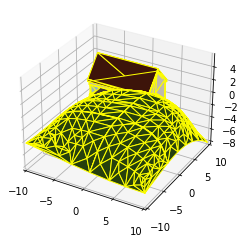

In [53]:
#https://stackoverflow.com/questions/56559379/plot-mesh-stored-as-vertices-and-faces

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for tri in trigs:
    v = tri["v"]
    f = tri["f"]
    pc = art3d.Poly3DCollection(v[f], facecolors=tri["c"][:3], edgecolor="yellow")
    ax.add_collection(pc)

#auto scaling doesnt work
allV = np.concatenate([trigs[_]["v"] for _ in range(len(trigs))])
maxV = allV.max(axis=0)
minV = allV.min(axis=0)
ax.set(xlim=(minV[0], maxV[0]), ylim=(minV[1], maxV[1]), zlim=(minV[2], maxV[2]))
plt.show()
